In [12]:
# Install necessary libraries
!pip install diffusers datasets transformers accelerate scipy ftfy

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

# Determine the device to use
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load your own dataset
dataset = load_dataset("mlnomad/imnet1k_sea_lion", split="train")  # Example dataset, replace with your dataset


# Create a subset of the first 1024 images
dataset = dataset.select(range(1024))

# Check the length of the subset
print(f"Length of the subset: {len(dataset)}")

# Preprocessing
image_size = 96
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transform to the dataset
dataset.set_transform(transform)

# Create a custom dataset class to return tensors directly
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

# Wrap the dataset in the custom class
tensor_dataset = TensorDataset(dataset)

# Create dataloader
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Model and scheduler
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 50 # Adjust as needed

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to(device)  # Move batch to device
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

Using device: cuda
Length of the subset: 1024
Epoch 0, Step 0: Loss = 1.1156753301620483
Epoch 1, Step 0: Loss = 0.30623379349708557
Epoch 2, Step 0: Loss = 0.1215750053524971
Epoch 3, Step 0: Loss = 0.11813131719827652
Epoch 4, Step 0: Loss = 0.07317836582660675
Epoch 5, Step 0: Loss = 0.06784701347351074
Epoch 6, Step 0: Loss = 0.08100594580173492
Epoch 7, Step 0: Loss = 0.0677943006157875
Epoch 8, Step 0: Loss = 0.09138590097427368
Epoch 9, Step 0: Loss = 0.0576554611325264
Epoch 10, Step 0: Loss = 0.037688352167606354
Epoch 11, Step 0: Loss = 0.03807418420910835
Epoch 12, Step 0: Loss = 0.07791014015674591
Epoch 13, Step 0: Loss = 0.05016845464706421
Epoch 14, Step 0: Loss = 0.0439533069729805
Epoch 15, Step 0: Loss = 0.030807338654994965
Epoch 16, Step 0: Loss = 0.060916654765605927
Epoch 17, Step 0: Loss = 0.030199522152543068
Epoch 18, Step 0: Loss = 0.06178300827741623
Epoch 19, Step 0: Loss = 0.08517278730869293
Epoch 20, Step 0: Loss = 0.10019107908010483
Epoch 21, Step 0: Lo

Length of the dataset: 1024


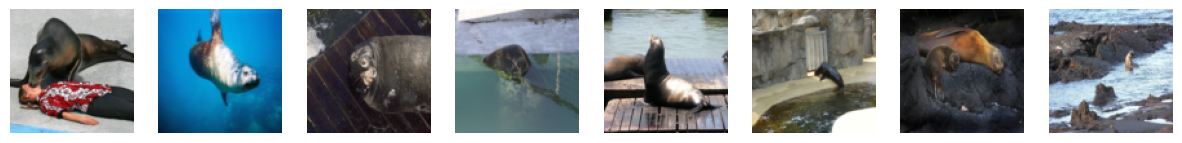

In [13]:
# Check the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

# Visualize 5 images
visualize_images(dataset, num_images=8)

## Generate images from the trained model

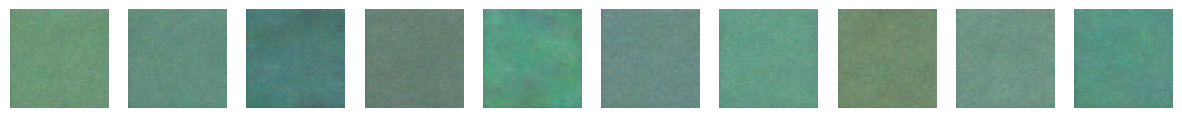

In [14]:
import torch
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# Function to generate images
def generate_images(num_images=1):
    with torch.no_grad():  # Disable gradient computation
        # Start from random noise
        noise = torch.randn((num_images, 3, 256, 256)).to("cuda")  # Match input dimensions
        images = noise

        # Denoising loop
        for t in noise_scheduler.timesteps:
            # Predict the noise residual
            noise_pred = model(images, t).sample

            # Compute the previous noisy sample x_t-1
            images = noise_scheduler.step(noise_pred, t, images).prev_sample

        # Convert images to CPU and denormalize
        images = images.detach().cpu()
        images = (images * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        images = torch.clamp(images, 0, 1)  # Clamp to valid pixel range
        return images

# Generate and visualize images
num_images = 10
generated_images = generate_images(num_images)

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

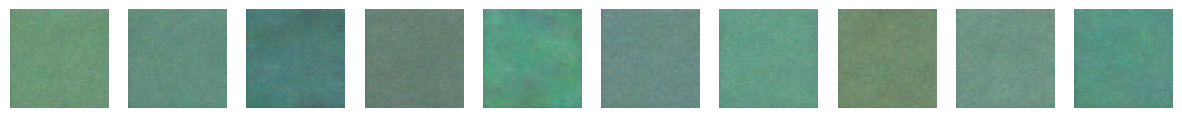

In [15]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [16]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'